# TensorFlow 2.0

In [1]:
from glob import glob

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt
%matplotlib inline

## Hyperparameter Tunning

In [2]:
num_epochs = 10
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [5]:
train_paths = glob('C:/Users/신상훈/Desktop/새 폴더/dataset/cifar/train/*.png')
test_paths = glob('C:/Users/신상훈/Desktop/새 폴더/dataset/cifar/test/*.png')

In [6]:
path = train_paths[0]
path

'C:/Users/신상훈/Desktop/새 폴더/dataset/cifar/train\\0_frog.png'

In [7]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [8]:
train_labels = [get_class_name(path) for path in train_paths]

In [9]:
class_names = np.unique(train_labels)
class_names

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [10]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return onehot

In [11]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [12]:
path

'C:/Users/신상훈/Desktop/새 폴더/dataset/cifar/train\\0_frog.png'

In [13]:
image, label = load_image_label(path)

In [14]:
np.min(image), np.max(image)

(0.0, 1.0)

In [15]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [16]:
image_preprocessed, label = image_preprocess(image, label)

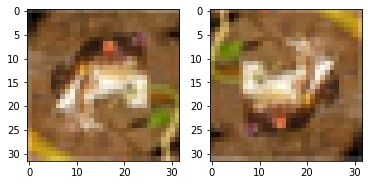

In [17]:
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(image_preprocessed)
plt.show()

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [20]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

# Learning Rate Scheduler

In [21]:
import math

In [22]:
def scheduler(epoch):
    if epoch <10:
        return 0.001
    else:
        return 0.001*math.exp(0.1*(10-epoch))

In [23]:
for epoch in range(10,20):
    print(0.001*math.exp(0.1*(10-epoch)))

0.001
0.0009048374180359595
0.0008187307530779819
0.0007408182206817179
0.0006703200460356394
0.0006065306597126335
0.0005488116360940264
0.0004965853037914095
0.0004493289641172216
0.00040656965974059914


In [24]:
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Checkpoint

In [25]:
save_path = 'checkpoints'

In [26]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

## Training

In [27]:
len(train_paths) // batch_size

1562

In [28]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

steps_per_epoch, validation_steps

(1562, 312)

In [29]:
image, label = next(iter(train_dataset))

In [30]:
image.shape, label.shape

(TensorShape([32, 32, 32, 3]), TensorShape([32, 10]))

In [31]:
model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=[learning_rate_scheduler],
)

SyntaxError: keyword argument repeated (<ipython-input-31-f445dec523f9>, line 8)

In [ ]:

model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=[checkpoint],
)